##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Actor-Critic 法による CartPole の実験


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic"> <img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/reinforcement_learning/actor_critic.ipynb"> <img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/reinforcement_learning/actor_critic.ipynb"> <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、[（深層）強化学習](https://en.wikipedia.org/wiki/Deep_reinforcement_learning)の[ポリシー勾配メソッド](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)を理解していることを前提に、TensorFlow を使用して [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) 法を実装し、[Open AI Gym](https://www.gymlibrary.dev/) の [`CartPole-v0`](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) 環境のエージェントをトレーニングする方法を示します。


**Actor-Critic 法**

Actor-Critic 法は、価値関数から独立してポリシー関数を表す[TD（時間的差分）学習](https://en.wikipedia.org/wiki/Temporal_difference_learning)の手法です。

ポリシー関数（またはポリシー）は、ある特定の状態に基づいてエージェントが実行できるアクションの確率分布を返します。価値関数は、特定の状態で開始し、その後永久に特定のポリシーに従って動作するエージェントの期待される戻り値を決定します。

Actor-Critic 法では、ポリシーは状態に応じて一連の可能なアクションを提案する「*アクター*」と呼ばれます。推定される価値関数は「*クリティック*’と呼ばれ、特定のポリシーに基づいて「*アクター*」が実行するアクションを評価します。

このチュートリアルでは、*アクター*と*クリティック*は、2 つの出力を持つ 1 つのニューラルネットワークを使って表現されます。


**`CartPole-v0`**

[`CartPole-v0` 環境](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)では、ポールは摩擦のないレール上を移動するカートに取り付けられています。ポールは直立状態で始まり、エージェントの目標は、カートに `-1` または `+1` の力を加えてポールが倒れないようにすることです。ポールが直立状態を維持する時間ステップごとに `+1` の報酬が与えられます。エピソードは、（1）ポールが直立から 15 度以上に傾斜したとき、または（2）カートが中央から 2.4 ユニット以上移動したときに、終了します。

<center>
  <pre data-md-type="custom_pre">&lt;figure&gt;
    &lt;image src="https://tensorflow.org/tutorials/reinforcement_learning/images/cartpole-v0.gif"&gt;
    &lt;figcaption&gt;
      Trained actor-critic model in Cartpole-v0 environment
    &lt;/figcaption&gt;
  &lt;/figure&gt;</pre>
</center>


この問題は、100 回の連続トライアルにおいて、エピソードの平均合計報酬が 195 に達すると「解決」とみなされます。

## セットアップ

必要なパッケージをインポートし、グローバル設定を構成します。


In [2]:
!pip install gym[classic_control]
!pip install pyglet

  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... - done


  Preparing metadata (pyproject.toml) ... -

 done


 \

 done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827620 sha256=8170d880af0e8c9336c9f2111586b5bd2f0af1f6dce1fe9c1bab4000085e5fef
  Stored in directory: /home/kbuilder/.cache/pip/wheels/af/2b/30/5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym


In [3]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y python-opengl > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [4]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

2024-01-11 20:25:03.412854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 20:25:03.412898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 20:25:03.414545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## モデル

*アクター*と*クリティック*は、アクションの確率とクリティック値をそれぞれ生成する 1 つのニューラルネットワークを使ってモデル化されます。このチュートリアルでは、モデルの定義にモデルのサブクラス化を使用します。

フォワードパス中、モデルは、状態を入力として取り、アクション確率とクリティック値 $V$ の両方を出力し、これによって状態に依存する[価値関数](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions)を形成します。期待される[戻り値](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return)を最大化するポリシー $\pi$ に基づいてアクションを選択するモデルをトレーニングするのが目標です。

`CartPole-v0` では、状態は 4 つの値で表現されます。カートの位置、カートの速度、ポールの角度、およびポールの速度です。エージェントは 2 つのアクションを取って、カートを左（`0`）と右（`1`）に押します。

詳細については、[Gym's Cart Pole ドキュメントページ](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)と Barto, Sutton and Anderson (1983) の「[*Neuronlike adaptive elements that can solve difficult learning control problems*](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)」をご覧ください。


In [5]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [6]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## エージェントをトレーニングする

エージェントをトレーニングするには、次の手順を実行します。

1. 環境でエージェントを実行し、エピソードごとのトレーニングデータを収集します。
2. 時間ステップごとに期待される戻り値を計算します。
3. Actor-Critic の混合モデルの損失を計算します。
4. 勾配を計算し、ネットワークパラメーターを更新します。
5. 成功基準または最大エピソード数に達するまで、1～4 の手順を繰り返します。


### 1. トレーニングデータを収集する

アクタークリティックモデルのトレーニングでは、教師あり学習と同様にトレーニングデータが必要です。ただし、そのようなデータを収集するには、モデルを環境で「実行」する必要があります。

トレーニングデータは、エピソードごとに収集されます。次に、モデルの重みによってパラメーター化された現在のポリシーに基づいてアクションの確率とクリティック値を生成するために、時間ステップごとにモデルのフォワードパスが環境の状態で実行されます。

次のアクションはモデルが生成したアクション確率からサンプリングされます。これが環境に適用されると、次の状態と報酬が生成されます。

このプロセスは、`run_episode` 関数に実装されます。後で TensorFlow グラフにコンパイルしてトレーニングを加速化できるように、TensorFlow 演算が使用されています。可変長配列でテンソルをイテレーションできるように、`tf.TensorArray` が使用されていることに注意してください。

In [7]:
# Wrap Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, truncated, info = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [8]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. 期待される戻り値を計算する

1 つのエピソード中に収集される各時間ステップ $t$ の報酬のシーケンス ${r_{t}}^{T}{t=1}$ は、期待される戻り値のシーケンス ${G{t}}^{T}_{t=1}$ に変換されます。ここで、報酬の合計は現在の時間ステップ $t$ ～ $T$ から取得され、各報酬は指数関数で気に減衰するディスカウント要因 $\gamma$ で乗算されます。

$$G_{t} = \sum^{T}*{t'=t} \gamma^{t'-t}r*{t'}$$

$\gamma\in(0,1)$ であるため、現在の時間ステップ以降の報酬には与えられる重みは、徐々に少なくなります。

直感的に、期待される戻り値は単に、現在の報酬が後の報酬より良いことを示しています。数学的に見れば、報酬の合計が収束することが保証されています。

トレーニングを安定化するには、生成される戻り値のシーケンスも標準化されます（つまり、平均と単位標準偏差がゼロ）。


In [9]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. Actor-Critic 損失

ハイブリッドの Actor-Critic モデルを使用しているため、選択される損失関数は、以下に示すように、トレーニング用のアクター損失とクリティック損失の合計です。

$$L = L_{actor} + L_{critic}$$

#### アクター損失

アクター損失は、[クリティックを状態依存の基準としたポリシー勾配](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s)に基づき、単一サンプル（エピソード単位）の推定で計算されます。

$$L_{actor} = -\sum^{T}*{t=1} log\pi*{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}*{\theta}(s*{t})]$$

上記は以下を意味します。

- $T$: エピソードごとの時間ステップの数。エピソードごとにことなります。
- $s_{t}$: 時間ステップ $t$ における状態。
- $a_{t}$: 状態 $s$ の場合の時間ステップ $t$ で選択されたアクション。
- $\pi_{\theta}$: $\theta$ でパラメータ化されたポリシー（アクター）。
- $V^{\pi}_{\theta}$: $\theta$ でパラメータ化された価値関数（クリティック）。
- $G = G_{t}$: 時間ステップ $t$ において特定の状態とアクションに対して期待される戻り値。

組み合わせの損失を最小限に抑えることでアクションがより高い報酬を生み出す確率を最大化しようとしているため、合計に負の項が追加されます。

<br>

##### アドバンテージ

$L_{actor}$ 式の $G - V$ の項は[アドバンテージ](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions)と呼ばれ、特定の状態において、あるアクションが、その状態のポリシー $\pi$ に従って選択されたランダムアクションと比べてどれくらい優れているかを示します。

ベースラインを除外することは可能ですが、除外した場合、トレーニング中のバリアンスが高くなってしまう可能性があります。また、ベースラインとしてクリティック $V$ を選択すると、できる限り $G$ に近くなるようにトレーニングされるため、バリアンスがより低くなります。

さらに、クリティックがなければ、アルゴリズムは特定の状態で実行されるアクションの確率を期待される戻り値に応じて高めようとするため、アクション間の相対的な確率が同じままである場合、結果はあまり変わりません。

たとえば、特定の状態における 2 つのアクションが同じ期待される戻り値を生成したとします。クリティックがなければ、アルゴリズムは客観的な $J$ に基づき、これらのアクションの確率をあげようとします。クリティックがあれば、アドバンテージがなく（$G - V = 0$）、そのためアクションの確率を上げることにアドバンテージがなく、アルゴリズムは勾配をゼロに設定します。

<br>

#### The Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

上記の $L_{\delta}$ は [Huber 損失](https://en.wikipedia.org/wiki/Huber_loss)でこれは、二乗誤差損失よりもデータの外れ値に対する感度が低くなります。


In [10]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. パラメータを更新するようにトレーニングステップを定義する

上記のすべてのステップは、エピソードごとに実行されるトレーニングステップに結合されます。損失関数に導くすべてのステップは、自動微分を可能にする `tf.GradientTape` コンテキストで実行されます。

このチュートリアルでは、Adam オプティマイザを使って勾配をモデルパラメーターに適用します。

ディスカウントされていない報酬の合計 `episode_reward` も、このステップで計算されます。この値は、成功基準が満たされるかどうかを評価するために、後で使用されます。

`tf.function` コンテキストは `train_step` 関数に適用することで、コーラブル TenSorFlow グラフにコンパイルできるようなります。そうすることで、トレーニングを 10 倍加速させることができます。


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. トレーニングツールを実行する

トレーニングは、成功基準またはエピソードの最大数に達するまでトレーニングステップを実行することで、実行されます。

エピソード報酬の実行中の記録はキューに保持されます。100 トライアルに達したら、キューの左終端（テール）から最も古い報酬が削除され、キューの右（ヘッド）に最も新しい報酬が追加されます。実行中の報酬の合計も、計算の効率を得るために管理されます。

ランタイムによっては、トレーニングを 1 分未満で完了することもできます。

In [12]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 500

# `CartPole-v1` is considered solved if average reward is >= 475 over 500 
# consecutive trials
reward_threshold = 475
running_reward = 0

# The discount factor for future rewards
gamma = 0.99

# Keep the last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

t = tqdm.trange(max_episodes)
for i in t:
    initial_state, info = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  

    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show the average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


I0000 00:00:1705004711.393610  544566 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  0%|          | 0/10000 [00:03<?, ?it/s, episode_reward=43, running_reward=43]

  0%|          | 1/10000 [00:03<10:33:41,  3.80s/it, episode_reward=43, running_reward=43]

  0%|          | 1/10000 [00:03<10:33:41,  3.80s/it, episode_reward=78, running_reward=60.5]

  0%|          | 1/10000 [00:03<10:33:41,  3.80s/it, episode_reward=63, running_reward=61.3]

  0%|          | 3/10000 [00:03<2:54:24,  1.05s/it, episode_reward=63, running_reward=61.3] 

  0%|          | 3/10000 [00:04<2:54:24,  1.05s/it, episode_reward=30, running_reward=53.5]

  0%|          | 3/10000 [00:04<2:54:24,  1.05s/it, episode_reward=74, running_reward=57.6]

  0%|          | 5/10000 [00:04<1:29:43,  1.86it/s, episode_reward=74, running_reward=57.6]

  0%|          | 5/10000 [00:04<1:29:43,  1.86it/s, episode_reward=50, running_reward=56.3]

  0%|          | 5/10000 [00:04<1:29:43,  1.86it/s, episode_reward=59, running_reward=56.7]

  0%|          | 7/10000 [00:04<56:14,  2.96it/s, episode_reward=59, running_reward=56.7]  

  0%|          | 7/10000 [00:04<56:14,  2.96it/s, episode_reward=20, running_reward=52.1]

  0%|          | 7/10000 [00:04<56:14,  2.96it/s, episode_reward=15, running_reward=48]  

  0%|          | 7/10000 [00:04<56:14,  2.96it/s, episode_reward=42, running_reward=47.4]

  0%|          | 7/10000 [00:04<56:14,  2.96it/s, episode_reward=26, running_reward=45.5]

  0%|          | 11/10000 [00:04<28:18,  5.88it/s, episode_reward=26, running_reward=45.5]

  0%|          | 11/10000 [00:04<28:18,  5.88it/s, episode_reward=22, running_reward=43.5]

  0%|          | 11/10000 [00:04<28:18,  5.88it/s, episode_reward=14, running_reward=41.2]

  0%|          | 11/10000 [00:04<28:18,  5.88it/s, episode_reward=14, running_reward=39.3]

  0%|          | 11/10000 [00:04<28:18,  5.88it/s, episode_reward=43, running_reward=39.5]

  0%|          | 15/10000 [00:04<17:58,  9.26it/s, episode_reward=43, running_reward=39.5]

  0%|          | 15/10000 [00:04<17:58,  9.26it/s, episode_reward=24, running_reward=38.6]

  0%|          | 15/10000 [00:04<17:58,  9.26it/s, episode_reward=17, running_reward=37.3]

  0%|          | 15/10000 [00:04<17:58,  9.26it/s, episode_reward=34, running_reward=37.1]

  0%|          | 15/10000 [00:04<17:58,  9.26it/s, episode_reward=67, running_reward=38.7]

  0%|          | 19/10000 [00:04<13:44, 12.10it/s, episode_reward=67, running_reward=38.7]

  0%|          | 19/10000 [00:04<13:44, 12.10it/s, episode_reward=76, running_reward=40.5]

  0%|          | 19/10000 [00:04<13:44, 12.10it/s, episode_reward=23, running_reward=39.7]

  0%|          | 19/10000 [00:04<13:44, 12.10it/s, episode_reward=29, running_reward=39.2]

  0%|          | 22/10000 [00:04<12:05, 13.75it/s, episode_reward=29, running_reward=39.2]

  0%|          | 22/10000 [00:04<12:05, 13.75it/s, episode_reward=118, running_reward=42.7]

  0%|          | 22/10000 [00:05<12:05, 13.75it/s, episode_reward=131, running_reward=46.3]

  0%|          | 22/10000 [00:05<12:05, 13.75it/s, episode_reward=78, running_reward=47.6] 

  0%|          | 25/10000 [00:05<14:10, 11.73it/s, episode_reward=78, running_reward=47.6]

  0%|          | 25/10000 [00:05<14:10, 11.73it/s, episode_reward=23, running_reward=46.7]

  0%|          | 25/10000 [00:05<14:10, 11.73it/s, episode_reward=65, running_reward=47.3]

  0%|          | 25/10000 [00:05<14:10, 11.73it/s, episode_reward=49, running_reward=47.4]

  0%|          | 28/10000 [00:05<12:28, 13.32it/s, episode_reward=49, running_reward=47.4]

  0%|          | 28/10000 [00:05<12:28, 13.32it/s, episode_reward=22, running_reward=46.5]

  0%|          | 28/10000 [00:05<12:28, 13.32it/s, episode_reward=24, running_reward=45.8]

  0%|          | 28/10000 [00:05<12:28, 13.32it/s, episode_reward=47, running_reward=45.8]

  0%|          | 31/10000 [00:05<10:33, 15.74it/s, episode_reward=47, running_reward=45.8]

  0%|          | 31/10000 [00:05<10:33, 15.74it/s, episode_reward=37, running_reward=45.5]

  0%|          | 31/10000 [00:05<10:33, 15.74it/s, episode_reward=31, running_reward=45.1]

  0%|          | 31/10000 [00:05<10:33, 15.74it/s, episode_reward=18, running_reward=44.3]

  0%|          | 34/10000 [00:05<09:05, 18.28it/s, episode_reward=18, running_reward=44.3]

  0%|          | 34/10000 [00:05<09:05, 18.28it/s, episode_reward=21, running_reward=43.6]

  0%|          | 34/10000 [00:05<09:05, 18.28it/s, episode_reward=36, running_reward=43.4]

  0%|          | 34/10000 [00:05<09:05, 18.28it/s, episode_reward=34, running_reward=43.2]

  0%|          | 37/10000 [00:05<08:07, 20.43it/s, episode_reward=34, running_reward=43.2]

  0%|          | 37/10000 [00:05<08:07, 20.43it/s, episode_reward=52, running_reward=43.4]

  0%|          | 37/10000 [00:05<08:07, 20.43it/s, episode_reward=35, running_reward=43.2]

  0%|          | 37/10000 [00:05<08:07, 20.43it/s, episode_reward=28, running_reward=42.8]

  0%|          | 40/10000 [00:05<07:51, 21.12it/s, episode_reward=28, running_reward=42.8]

  0%|          | 40/10000 [00:05<07:51, 21.12it/s, episode_reward=28, running_reward=42.4]

  0%|          | 40/10000 [00:05<07:51, 21.12it/s, episode_reward=33, running_reward=42.2]

  0%|          | 40/10000 [00:05<07:51, 21.12it/s, episode_reward=22, running_reward=41.7]

  0%|          | 40/10000 [00:05<07:51, 21.12it/s, episode_reward=38, running_reward=41.7]

  0%|          | 44/10000 [00:05<07:08, 23.23it/s, episode_reward=38, running_reward=41.7]

  0%|          | 44/10000 [00:05<07:08, 23.23it/s, episode_reward=26, running_reward=41.3]

  0%|          | 44/10000 [00:05<07:08, 23.23it/s, episode_reward=37, running_reward=41.2]

  0%|          | 44/10000 [00:05<07:08, 23.23it/s, episode_reward=27, running_reward=40.9]

  0%|          | 47/10000 [00:05<06:50, 24.27it/s, episode_reward=27, running_reward=40.9]

  0%|          | 47/10000 [00:05<06:50, 24.27it/s, episode_reward=29, running_reward=40.7]

  0%|          | 47/10000 [00:06<06:50, 24.27it/s, episode_reward=36, running_reward=40.6]

  0%|          | 47/10000 [00:06<06:50, 24.27it/s, episode_reward=35, running_reward=40.5]

  0%|          | 50/10000 [00:06<06:42, 24.73it/s, episode_reward=35, running_reward=40.5]

  0%|          | 50/10000 [00:06<06:42, 24.73it/s, episode_reward=37, running_reward=40.4]

  0%|          | 50/10000 [00:06<06:42, 24.73it/s, episode_reward=29, running_reward=40.2]

  0%|          | 50/10000 [00:06<06:42, 24.73it/s, episode_reward=26, running_reward=39.9]

  1%|          | 53/10000 [00:06<06:28, 25.58it/s, episode_reward=26, running_reward=39.9]

  1%|          | 53/10000 [00:06<06:28, 25.58it/s, episode_reward=35, running_reward=39.8]

  1%|          | 53/10000 [00:06<06:28, 25.58it/s, episode_reward=15, running_reward=39.4]

  1%|          | 53/10000 [00:06<06:28, 25.58it/s, episode_reward=13, running_reward=38.9]

  1%|          | 53/10000 [00:06<06:28, 25.58it/s, episode_reward=15, running_reward=38.5]

  1%|          | 53/10000 [00:06<06:28, 25.58it/s, episode_reward=10, running_reward=38]  

  1%|          | 58/10000 [00:06<05:16, 31.42it/s, episode_reward=10, running_reward=38]

  1%|          | 58/10000 [00:06<05:16, 31.42it/s, episode_reward=35, running_reward=37.9]

  1%|          | 58/10000 [00:06<05:16, 31.42it/s, episode_reward=12, running_reward=37.5]

  1%|          | 58/10000 [00:06<05:16, 31.42it/s, episode_reward=29, running_reward=37.4]

  1%|          | 58/10000 [00:06<05:16, 31.42it/s, episode_reward=21, running_reward=37.1]

  1%|          | 62/10000 [00:06<05:05, 32.48it/s, episode_reward=21, running_reward=37.1]

  1%|          | 62/10000 [00:06<05:05, 32.48it/s, episode_reward=28, running_reward=37]  

  1%|          | 62/10000 [00:06<05:05, 32.48it/s, episode_reward=22, running_reward=36.7]

  1%|          | 62/10000 [00:06<05:05, 32.48it/s, episode_reward=19, running_reward=36.4]

  1%|          | 62/10000 [00:06<05:05, 32.48it/s, episode_reward=20, running_reward=36.2]

  1%|          | 66/10000 [00:06<04:52, 33.92it/s, episode_reward=20, running_reward=36.2]

  1%|          | 66/10000 [00:06<04:52, 33.92it/s, episode_reward=12, running_reward=35.8]

  1%|          | 66/10000 [00:06<04:52, 33.92it/s, episode_reward=24, running_reward=35.7]

  1%|          | 66/10000 [00:06<04:52, 33.92it/s, episode_reward=27, running_reward=35.5]

  1%|          | 66/10000 [00:06<04:52, 33.92it/s, episode_reward=13, running_reward=35.2]

  1%|          | 66/10000 [00:06<04:52, 33.92it/s, episode_reward=16, running_reward=34.9]

  1%|          | 71/10000 [00:06<04:27, 37.19it/s, episode_reward=16, running_reward=34.9]

  1%|          | 71/10000 [00:06<04:27, 37.19it/s, episode_reward=29, running_reward=34.9]

  1%|          | 71/10000 [00:06<04:27, 37.19it/s, episode_reward=28, running_reward=34.8]

  1%|          | 71/10000 [00:06<04:27, 37.19it/s, episode_reward=38, running_reward=34.8]

  1%|          | 71/10000 [00:06<04:27, 37.19it/s, episode_reward=30, running_reward=34.7]

  1%|          | 75/10000 [00:06<04:53, 33.81it/s, episode_reward=30, running_reward=34.7]

  1%|          | 75/10000 [00:06<04:53, 33.81it/s, episode_reward=25, running_reward=34.6]

  1%|          | 75/10000 [00:06<04:53, 33.81it/s, episode_reward=15, running_reward=34.4]

  1%|          | 75/10000 [00:06<04:53, 33.81it/s, episode_reward=19, running_reward=34.2]

  1%|          | 75/10000 [00:06<04:53, 33.81it/s, episode_reward=16, running_reward=33.9]

  1%|          | 75/10000 [00:06<04:53, 33.81it/s, episode_reward=23, running_reward=33.8]

  1%|          | 80/10000 [00:06<04:33, 36.21it/s, episode_reward=23, running_reward=33.8]

  1%|          | 80/10000 [00:06<04:33, 36.21it/s, episode_reward=20, running_reward=33.6]

  1%|          | 80/10000 [00:06<04:33, 36.21it/s, episode_reward=30, running_reward=33.6]

  1%|          | 80/10000 [00:06<04:33, 36.21it/s, episode_reward=23, running_reward=33.5]

  1%|          | 80/10000 [00:07<04:33, 36.21it/s, episode_reward=26, running_reward=33.4]

  1%|          | 84/10000 [00:07<04:42, 35.14it/s, episode_reward=26, running_reward=33.4]

  1%|          | 84/10000 [00:07<04:42, 35.14it/s, episode_reward=39, running_reward=33.4]

  1%|          | 84/10000 [00:07<04:42, 35.14it/s, episode_reward=30, running_reward=33.4]

  1%|          | 84/10000 [00:07<04:42, 35.14it/s, episode_reward=26, running_reward=33.3]

  1%|          | 84/10000 [00:07<04:42, 35.14it/s, episode_reward=20, running_reward=33.2]

  1%|          | 88/10000 [00:07<04:57, 33.31it/s, episode_reward=20, running_reward=33.2]

  1%|          | 88/10000 [00:07<04:57, 33.31it/s, episode_reward=27, running_reward=33.1]

  1%|          | 88/10000 [00:07<04:57, 33.31it/s, episode_reward=59, running_reward=33.4]

  1%|          | 88/10000 [00:07<04:57, 33.31it/s, episode_reward=19, running_reward=33.2]

  1%|          | 88/10000 [00:07<04:57, 33.31it/s, episode_reward=57, running_reward=33.5]

  1%|          | 92/10000 [00:07<05:46, 28.61it/s, episode_reward=57, running_reward=33.5]

  1%|          | 92/10000 [00:07<05:46, 28.61it/s, episode_reward=41, running_reward=33.6]

  1%|          | 92/10000 [00:07<05:46, 28.61it/s, episode_reward=46, running_reward=33.7]

  1%|          | 92/10000 [00:07<05:46, 28.61it/s, episode_reward=68, running_reward=34.1]

  1%|          | 92/10000 [00:07<05:46, 28.61it/s, episode_reward=41, running_reward=34.1]

  1%|          | 96/10000 [00:07<06:43, 24.53it/s, episode_reward=41, running_reward=34.1]

  1%|          | 96/10000 [00:07<06:43, 24.53it/s, episode_reward=215, running_reward=36] 

  1%|          | 96/10000 [00:07<06:43, 24.53it/s, episode_reward=73, running_reward=36.4]

  1%|          | 96/10000 [00:07<06:43, 24.53it/s, episode_reward=87, running_reward=36.9]

  1%|          | 99/10000 [00:07<10:12, 16.17it/s, episode_reward=87, running_reward=36.9]

  1%|          | 99/10000 [00:07<10:12, 16.17it/s, episode_reward=50, running_reward=37]  

  1%|          | 99/10000 [00:08<10:12, 16.17it/s, episode_reward=121, running_reward=37.8]

  1%|          | 99/10000 [00:08<10:12, 16.17it/s, episode_reward=55, running_reward=37.6] 

  1%|          | 102/10000 [00:08<10:59, 15.00it/s, episode_reward=55, running_reward=37.6]

  1%|          | 102/10000 [00:08<10:59, 15.00it/s, episode_reward=53, running_reward=37.5]

  1%|          | 102/10000 [00:08<10:59, 15.00it/s, episode_reward=114, running_reward=38.3]

  1%|          | 104/10000 [00:08<11:38, 14.17it/s, episode_reward=114, running_reward=38.3]

  1%|          | 104/10000 [00:08<11:38, 14.17it/s, episode_reward=56, running_reward=38.1] 

  1%|          | 104/10000 [00:08<11:38, 14.17it/s, episode_reward=38, running_reward=38]  

  1%|          | 106/10000 [00:08<10:59, 15.00it/s, episode_reward=38, running_reward=38]

  1%|          | 106/10000 [00:08<10:59, 15.00it/s, episode_reward=71, running_reward=38.1]

  1%|          | 106/10000 [00:08<10:59, 15.00it/s, episode_reward=291, running_reward=40.8]

  1%|          | 108/10000 [00:08<15:38, 10.54it/s, episode_reward=291, running_reward=40.8]

  1%|          | 108/10000 [00:09<15:38, 10.54it/s, episode_reward=258, running_reward=43.3]

  1%|          | 108/10000 [00:09<15:38, 10.54it/s, episode_reward=91, running_reward=43.8] 

  1%|          | 110/10000 [00:09<19:07,  8.62it/s, episode_reward=91, running_reward=43.8]

  1%|          | 110/10000 [00:09<19:07,  8.62it/s, episode_reward=90, running_reward=44.4]

  1%|          | 110/10000 [00:09<19:07,  8.62it/s, episode_reward=412, running_reward=48.3]

  1%|          | 112/10000 [00:09<24:58,  6.60it/s, episode_reward=412, running_reward=48.3]

  1%|          | 112/10000 [00:09<24:58,  6.60it/s, episode_reward=94, running_reward=49.1] 

  1%|          | 112/10000 [00:09<24:58,  6.60it/s, episode_reward=122, running_reward=50.2]

  1%|          | 114/10000 [00:09<23:07,  7.12it/s, episode_reward=122, running_reward=50.2]

  1%|          | 114/10000 [00:10<23:07,  7.12it/s, episode_reward=98, running_reward=50.7] 

  1%|          | 114/10000 [00:10<23:07,  7.12it/s, episode_reward=78, running_reward=51.3]

  1%|          | 116/10000 [00:10<20:54,  7.88it/s, episode_reward=78, running_reward=51.3]

  1%|          | 116/10000 [00:10<20:54,  7.88it/s, episode_reward=116, running_reward=52.2]

  1%|          | 117/10000 [00:10<20:46,  7.93it/s, episode_reward=116, running_reward=52.2]

  1%|          | 117/10000 [00:10<20:46,  7.93it/s, episode_reward=67, running_reward=52.6] 

  1%|          | 117/10000 [00:10<20:46,  7.93it/s, episode_reward=234, running_reward=54.2]

  1%|          | 119/10000 [00:10<22:13,  7.41it/s, episode_reward=234, running_reward=54.2]

  1%|          | 119/10000 [00:10<22:13,  7.41it/s, episode_reward=128, running_reward=54.8]

  1%|          | 120/10000 [00:10<22:06,  7.45it/s, episode_reward=128, running_reward=54.8]

  1%|          | 120/10000 [00:10<22:06,  7.45it/s, episode_reward=114, running_reward=55.7]

  1%|          | 121/10000 [00:10<21:34,  7.63it/s, episode_reward=114, running_reward=55.7]

  1%|          | 121/10000 [00:10<21:34,  7.63it/s, episode_reward=72, running_reward=56.1] 

  1%|          | 121/10000 [00:10<21:34,  7.63it/s, episode_reward=81, running_reward=55.7]

  1%|          | 123/10000 [00:10<18:24,  8.94it/s, episode_reward=81, running_reward=55.7]

  1%|          | 123/10000 [00:10<18:24,  8.94it/s, episode_reward=40, running_reward=54.8]

  1%|          | 123/10000 [00:11<18:24,  8.94it/s, episode_reward=53, running_reward=54.6]

  1%|▏         | 125/10000 [00:11<14:53, 11.05it/s, episode_reward=53, running_reward=54.6]

  1%|▏         | 125/10000 [00:11<14:53, 11.05it/s, episode_reward=57, running_reward=54.9]

  1%|▏         | 125/10000 [00:11<14:53, 11.05it/s, episode_reward=96, running_reward=55.2]

  1%|▏         | 127/10000 [00:11<14:37, 11.25it/s, episode_reward=96, running_reward=55.2]

  1%|▏         | 127/10000 [00:11<14:37, 11.25it/s, episode_reward=130, running_reward=56] 

  1%|▏         | 127/10000 [00:11<14:37, 11.25it/s, episode_reward=230, running_reward=58.1]

  1%|▏         | 129/10000 [00:11<20:23,  8.07it/s, episode_reward=230, running_reward=58.1]

  1%|▏         | 129/10000 [00:11<20:23,  8.07it/s, episode_reward=165, running_reward=59.5]

  1%|▏         | 129/10000 [00:11<20:23,  8.07it/s, episode_reward=137, running_reward=60.4]

  1%|▏         | 131/10000 [00:11<22:19,  7.37it/s, episode_reward=137, running_reward=60.4]

  1%|▏         | 131/10000 [00:12<22:19,  7.37it/s, episode_reward=161, running_reward=61.7]

  1%|▏         | 132/10000 [00:12<23:20,  7.05it/s, episode_reward=161, running_reward=61.7]

  1%|▏         | 132/10000 [00:12<23:20,  7.05it/s, episode_reward=121, running_reward=62.6]

  1%|▏         | 133/10000 [00:12<23:21,  7.04it/s, episode_reward=121, running_reward=62.6]

  1%|▏         | 133/10000 [00:12<23:21,  7.04it/s, episode_reward=132, running_reward=63.7]

  1%|▏         | 134/10000 [00:12<23:24,  7.02it/s, episode_reward=132, running_reward=63.7]

  1%|▏         | 134/10000 [00:12<23:24,  7.02it/s, episode_reward=102, running_reward=64.5]

  1%|▏         | 135/10000 [00:12<22:22,  7.35it/s, episode_reward=102, running_reward=64.5]

  1%|▏         | 135/10000 [00:12<22:22,  7.35it/s, episode_reward=139, running_reward=65.5]

  1%|▏         | 136/10000 [00:12<23:33,  6.98it/s, episode_reward=139, running_reward=65.5]

  1%|▏         | 136/10000 [00:12<23:33,  6.98it/s, episode_reward=121, running_reward=66.4]

  1%|▏         | 137/10000 [00:12<23:51,  6.89it/s, episode_reward=121, running_reward=66.4]

  1%|▏         | 137/10000 [00:13<23:51,  6.89it/s, episode_reward=228, running_reward=68.2]

  1%|▏         | 138/10000 [00:13<28:49,  5.70it/s, episode_reward=228, running_reward=68.2]

  1%|▏         | 138/10000 [00:13<28:49,  5.70it/s, episode_reward=171, running_reward=69.5]

  1%|▏         | 139/10000 [00:13<29:01,  5.66it/s, episode_reward=171, running_reward=69.5]

  1%|▏         | 139/10000 [00:13<29:01,  5.66it/s, episode_reward=128, running_reward=70.5]

  1%|▏         | 140/10000 [00:13<27:24,  5.99it/s, episode_reward=128, running_reward=70.5]

  1%|▏         | 140/10000 [00:13<27:24,  5.99it/s, episode_reward=129, running_reward=71.5]

  1%|▏         | 141/10000 [00:13<26:35,  6.18it/s, episode_reward=129, running_reward=71.5]

  1%|▏         | 141/10000 [00:13<26:35,  6.18it/s, episode_reward=124, running_reward=72.5]

  1%|▏         | 142/10000 [00:13<25:18,  6.49it/s, episode_reward=124, running_reward=72.5]

  1%|▏         | 142/10000 [00:13<25:18,  6.49it/s, episode_reward=173, running_reward=74]  

  1%|▏         | 143/10000 [00:13<26:41,  6.16it/s, episode_reward=173, running_reward=74]

  1%|▏         | 143/10000 [00:13<26:41,  6.16it/s, episode_reward=119, running_reward=74.8]

  1%|▏         | 144/10000 [00:13<24:58,  6.58it/s, episode_reward=119, running_reward=74.8]

  1%|▏         | 144/10000 [00:14<24:58,  6.58it/s, episode_reward=126, running_reward=75.8]

  1%|▏         | 145/10000 [00:14<24:12,  6.78it/s, episode_reward=126, running_reward=75.8]

  1%|▏         | 145/10000 [00:14<24:12,  6.78it/s, episode_reward=138, running_reward=76.8]

  1%|▏         | 146/10000 [00:14<24:09,  6.80it/s, episode_reward=138, running_reward=76.8]

  1%|▏         | 146/10000 [00:14<24:09,  6.80it/s, episode_reward=125, running_reward=77.8]

  1%|▏         | 147/10000 [00:14<23:22,  7.02it/s, episode_reward=125, running_reward=77.8]

  1%|▏         | 147/10000 [00:14<23:22,  7.02it/s, episode_reward=130, running_reward=78.8]

  1%|▏         | 148/10000 [00:14<23:14,  7.07it/s, episode_reward=130, running_reward=78.8]

  1%|▏         | 148/10000 [00:14<23:14,  7.07it/s, episode_reward=127, running_reward=79.7]

  1%|▏         | 149/10000 [00:14<22:54,  7.17it/s, episode_reward=127, running_reward=79.7]

  1%|▏         | 149/10000 [00:14<22:54,  7.17it/s, episode_reward=105, running_reward=80.4]

  2%|▏         | 150/10000 [00:14<21:47,  7.53it/s, episode_reward=105, running_reward=80.4]

  2%|▏         | 150/10000 [00:14<21:47,  7.53it/s, episode_reward=128, running_reward=81.3]

  2%|▏         | 151/10000 [00:14<22:06,  7.43it/s, episode_reward=128, running_reward=81.3]

  2%|▏         | 151/10000 [00:15<22:06,  7.43it/s, episode_reward=160, running_reward=82.6]

  2%|▏         | 152/10000 [00:15<23:59,  6.84it/s, episode_reward=160, running_reward=82.6]

  2%|▏         | 152/10000 [00:15<23:59,  6.84it/s, episode_reward=215, running_reward=84.5]

  2%|▏         | 153/10000 [00:15<28:29,  5.76it/s, episode_reward=215, running_reward=84.5]

  2%|▏         | 153/10000 [00:15<28:29,  5.76it/s, episode_reward=198, running_reward=86.1]

  2%|▏         | 154/10000 [00:15<30:04,  5.45it/s, episode_reward=198, running_reward=86.1]

  2%|▏         | 154/10000 [00:15<30:04,  5.45it/s, episode_reward=271, running_reward=88.7]

  2%|▏         | 155/10000 [00:15<35:19,  4.64it/s, episode_reward=271, running_reward=88.7]

  2%|▏         | 155/10000 [00:16<35:19,  4.64it/s, episode_reward=351, running_reward=92.1]

  2%|▏         | 156/10000 [00:16<42:43,  3.84it/s, episode_reward=351, running_reward=92.1]

  2%|▏         | 156/10000 [00:16<42:43,  3.84it/s, episode_reward=349, running_reward=95.4]

  2%|▏         | 157/10000 [00:16<47:03,  3.49it/s, episode_reward=349, running_reward=95.4]

  2%|▏         | 157/10000 [00:17<47:03,  3.49it/s, episode_reward=500, running_reward=100] 

  2%|▏         | 158/10000 [00:17<57:02,  2.88it/s, episode_reward=500, running_reward=100]

  2%|▏         | 158/10000 [00:17<57:02,  2.88it/s, episode_reward=500, running_reward=105]

  2%|▏         | 159/10000 [00:17<1:04:20,  2.55it/s, episode_reward=500, running_reward=105]

  2%|▏         | 159/10000 [00:18<1:04:20,  2.55it/s, episode_reward=500, running_reward=110]

  2%|▏         | 160/10000 [00:18<1:10:45,  2.32it/s, episode_reward=500, running_reward=110]

  2%|▏         | 160/10000 [00:18<1:10:45,  2.32it/s, episode_reward=362, running_reward=113]

  2%|▏         | 161/10000 [00:18<1:08:58,  2.38it/s, episode_reward=362, running_reward=113]

  2%|▏         | 161/10000 [00:18<1:08:58,  2.38it/s, episode_reward=237, running_reward=115]

  2%|▏         | 162/10000 [00:18<1:00:19,  2.72it/s, episode_reward=237, running_reward=115]

  2%|▏         | 162/10000 [00:18<1:00:19,  2.72it/s, episode_reward=208, running_reward=117]

  2%|▏         | 163/10000 [00:18<53:25,  3.07it/s, episode_reward=208, running_reward=117]  

  2%|▏         | 163/10000 [00:19<53:25,  3.07it/s, episode_reward=94, running_reward=118] 

  2%|▏         | 164/10000 [00:19<42:29,  3.86it/s, episode_reward=94, running_reward=118]

  2%|▏         | 164/10000 [00:19<42:29,  3.86it/s, episode_reward=95, running_reward=119]

  2%|▏         | 165/10000 [00:19<34:43,  4.72it/s, episode_reward=95, running_reward=119]

  2%|▏         | 165/10000 [00:19<34:43,  4.72it/s, episode_reward=107, running_reward=119]

  2%|▏         | 166/10000 [00:19<29:47,  5.50it/s, episode_reward=107, running_reward=119]

  2%|▏         | 166/10000 [00:19<29:47,  5.50it/s, episode_reward=57, running_reward=120] 

  2%|▏         | 166/10000 [00:19<29:47,  5.50it/s, episode_reward=75, running_reward=120]

  2%|▏         | 168/10000 [00:19<21:22,  7.67it/s, episode_reward=75, running_reward=120]

  2%|▏         | 168/10000 [00:19<21:22,  7.67it/s, episode_reward=93, running_reward=121]

  2%|▏         | 168/10000 [00:19<21:22,  7.67it/s, episode_reward=96, running_reward=122]

  2%|▏         | 170/10000 [00:19<19:18,  8.48it/s, episode_reward=96, running_reward=122]

  2%|▏         | 170/10000 [00:19<19:18,  8.48it/s, episode_reward=72, running_reward=122]

  2%|▏         | 170/10000 [00:19<19:18,  8.48it/s, episode_reward=40, running_reward=123]

  2%|▏         | 172/10000 [00:19<16:04, 10.19it/s, episode_reward=40, running_reward=123]

  2%|▏         | 172/10000 [00:19<16:04, 10.19it/s, episode_reward=127, running_reward=124]

  2%|▏         | 172/10000 [00:19<16:04, 10.19it/s, episode_reward=68, running_reward=124] 

  2%|▏         | 174/10000 [00:19<16:18, 10.04it/s, episode_reward=68, running_reward=124]

  2%|▏         | 174/10000 [00:19<16:18, 10.04it/s, episode_reward=56, running_reward=124]

  2%|▏         | 174/10000 [00:20<16:18, 10.04it/s, episode_reward=109, running_reward=125]

  2%|▏         | 176/10000 [00:20<15:52, 10.32it/s, episode_reward=109, running_reward=125]

  2%|▏         | 176/10000 [00:20<15:52, 10.32it/s, episode_reward=85, running_reward=126] 

  2%|▏         | 176/10000 [00:20<15:52, 10.32it/s, episode_reward=70, running_reward=126]

  2%|▏         | 178/10000 [00:20<15:08, 10.82it/s, episode_reward=70, running_reward=126]

  2%|▏         | 178/10000 [00:20<15:08, 10.82it/s, episode_reward=79, running_reward=127]

  2%|▏         | 178/10000 [00:20<15:08, 10.82it/s, episode_reward=35, running_reward=127]

  2%|▏         | 180/10000 [00:20<13:37, 12.01it/s, episode_reward=35, running_reward=127]

  2%|▏         | 180/10000 [00:20<13:37, 12.01it/s, episode_reward=75, running_reward=128]

  2%|▏         | 180/10000 [00:20<13:37, 12.01it/s, episode_reward=107, running_reward=128]

  2%|▏         | 182/10000 [00:20<14:21, 11.40it/s, episode_reward=107, running_reward=128]

  2%|▏         | 182/10000 [00:20<14:21, 11.40it/s, episode_reward=83, running_reward=129] 

  2%|▏         | 182/10000 [00:20<14:21, 11.40it/s, episode_reward=159, running_reward=130]

  2%|▏         | 184/10000 [00:20<16:32,  9.89it/s, episode_reward=159, running_reward=130]

  2%|▏         | 184/10000 [00:20<16:32,  9.89it/s, episode_reward=66, running_reward=130] 

  2%|▏         | 184/10000 [00:21<16:32,  9.89it/s, episode_reward=92, running_reward=131]

  2%|▏         | 186/10000 [00:21<15:59, 10.23it/s, episode_reward=92, running_reward=131]

  2%|▏         | 186/10000 [00:21<15:59, 10.23it/s, episode_reward=87, running_reward=132]

  2%|▏         | 186/10000 [00:21<15:59, 10.23it/s, episode_reward=34, running_reward=132]

  2%|▏         | 188/10000 [00:21<14:37, 11.18it/s, episode_reward=34, running_reward=132]

  2%|▏         | 188/10000 [00:21<14:37, 11.18it/s, episode_reward=115, running_reward=133]

  2%|▏         | 188/10000 [00:21<14:37, 11.18it/s, episode_reward=53, running_reward=133] 

  2%|▏         | 190/10000 [00:21<14:50, 11.02it/s, episode_reward=53, running_reward=133]

  2%|▏         | 190/10000 [00:21<14:50, 11.02it/s, episode_reward=110, running_reward=134]

  2%|▏         | 190/10000 [00:21<14:50, 11.02it/s, episode_reward=143, running_reward=134]

  2%|▏         | 192/10000 [00:21<17:02,  9.59it/s, episode_reward=143, running_reward=134]

  2%|▏         | 192/10000 [00:21<17:02,  9.59it/s, episode_reward=103, running_reward=135]

  2%|▏         | 192/10000 [00:21<17:02,  9.59it/s, episode_reward=125, running_reward=136]

  2%|▏         | 194/10000 [00:21<17:39,  9.25it/s, episode_reward=125, running_reward=136]

  2%|▏         | 194/10000 [00:22<17:39,  9.25it/s, episode_reward=139, running_reward=137]

  2%|▏         | 195/10000 [00:22<18:54,  8.64it/s, episode_reward=139, running_reward=137]

  2%|▏         | 195/10000 [00:22<18:54,  8.64it/s, episode_reward=223, running_reward=138]

  2%|▏         | 196/10000 [00:22<23:01,  7.10it/s, episode_reward=223, running_reward=138]

  2%|▏         | 196/10000 [00:22<23:01,  7.10it/s, episode_reward=196, running_reward=138]

  2%|▏         | 197/10000 [00:22<25:35,  6.38it/s, episode_reward=196, running_reward=138]

  2%|▏         | 197/10000 [00:22<25:35,  6.38it/s, episode_reward=161, running_reward=139]

  2%|▏         | 198/10000 [00:22<26:26,  6.18it/s, episode_reward=161, running_reward=139]

  2%|▏         | 198/10000 [00:22<26:26,  6.18it/s, episode_reward=131, running_reward=140]

  2%|▏         | 199/10000 [00:22<25:43,  6.35it/s, episode_reward=131, running_reward=140]

  2%|▏         | 199/10000 [00:22<25:43,  6.35it/s, episode_reward=124, running_reward=140]

  2%|▏         | 200/10000 [00:22<24:32,  6.66it/s, episode_reward=124, running_reward=140]

  2%|▏         | 200/10000 [00:23<24:32,  6.66it/s, episode_reward=154, running_reward=141]

  2%|▏         | 201/10000 [00:23<25:23,  6.43it/s, episode_reward=154, running_reward=141]

  2%|▏         | 201/10000 [00:23<25:23,  6.43it/s, episode_reward=152, running_reward=142]

  2%|▏         | 202/10000 [00:23<25:27,  6.42it/s, episode_reward=152, running_reward=142]

  2%|▏         | 202/10000 [00:23<25:27,  6.42it/s, episode_reward=149, running_reward=142]

  2%|▏         | 203/10000 [00:23<25:25,  6.42it/s, episode_reward=149, running_reward=142]

  2%|▏         | 203/10000 [00:23<25:25,  6.42it/s, episode_reward=151, running_reward=143]

  2%|▏         | 204/10000 [00:23<25:40,  6.36it/s, episode_reward=151, running_reward=143]

  2%|▏         | 204/10000 [00:23<25:40,  6.36it/s, episode_reward=174, running_reward=144]

  2%|▏         | 205/10000 [00:23<26:41,  6.12it/s, episode_reward=174, running_reward=144]

  2%|▏         | 205/10000 [00:23<26:41,  6.12it/s, episode_reward=253, running_reward=146]

  2%|▏         | 206/10000 [00:23<31:00,  5.26it/s, episode_reward=253, running_reward=146]

  2%|▏         | 206/10000 [00:24<31:00,  5.26it/s, episode_reward=150, running_reward=147]

  2%|▏         | 207/10000 [00:24<29:10,  5.59it/s, episode_reward=150, running_reward=147]

  2%|▏         | 207/10000 [00:24<29:10,  5.59it/s, episode_reward=231, running_reward=146]

  2%|▏         | 208/10000 [00:24<31:47,  5.13it/s, episode_reward=231, running_reward=146]

  2%|▏         | 208/10000 [00:24<31:47,  5.13it/s, episode_reward=157, running_reward=145]

  2%|▏         | 209/10000 [00:24<30:07,  5.42it/s, episode_reward=157, running_reward=145]

  2%|▏         | 209/10000 [00:24<30:07,  5.42it/s, episode_reward=93, running_reward=145] 

  2%|▏         | 209/10000 [00:24<30:07,  5.42it/s, episode_reward=356, running_reward=148]

  2%|▏         | 211/10000 [00:24<33:04,  4.93it/s, episode_reward=356, running_reward=148]

  2%|▏         | 211/10000 [00:25<33:04,  4.93it/s, episode_reward=393, running_reward=148]

  2%|▏         | 212/10000 [00:25<40:39,  4.01it/s, episode_reward=393, running_reward=148]

  2%|▏         | 212/10000 [00:25<40:39,  4.01it/s, episode_reward=500, running_reward=152]

  2%|▏         | 213/10000 [00:25<50:59,  3.20it/s, episode_reward=500, running_reward=152]

  2%|▏         | 213/10000 [00:26<50:59,  3.20it/s, episode_reward=500, running_reward=156]

  2%|▏         | 214/10000 [00:26<59:55,  2.72it/s, episode_reward=500, running_reward=156]

  2%|▏         | 214/10000 [00:26<59:55,  2.72it/s, episode_reward=500, running_reward=160]

  2%|▏         | 215/10000 [00:26<1:06:17,  2.46it/s, episode_reward=500, running_reward=160]

  2%|▏         | 215/10000 [00:27<1:06:17,  2.46it/s, episode_reward=500, running_reward=164]

  2%|▏         | 216/10000 [00:27<1:12:02,  2.26it/s, episode_reward=500, running_reward=164]

  2%|▏         | 216/10000 [00:27<1:12:02,  2.26it/s, episode_reward=447, running_reward=167]

  2%|▏         | 217/10000 [00:27<1:12:41,  2.24it/s, episode_reward=447, running_reward=167]

  2%|▏         | 217/10000 [00:28<1:12:41,  2.24it/s, episode_reward=500, running_reward=172]

  2%|▏         | 218/10000 [00:28<1:17:00,  2.12it/s, episode_reward=500, running_reward=172]

  2%|▏         | 218/10000 [00:28<1:17:00,  2.12it/s, episode_reward=500, running_reward=174]

  2%|▏         | 219/10000 [00:28<1:18:01,  2.09it/s, episode_reward=500, running_reward=174]

  2%|▏         | 219/10000 [00:29<1:18:01,  2.09it/s, episode_reward=500, running_reward=178]

  2%|▏         | 220/10000 [00:29<1:18:43,  2.07it/s, episode_reward=500, running_reward=178]

  2%|▏         | 220/10000 [00:29<1:18:43,  2.07it/s, episode_reward=500, running_reward=182]

  2%|▏         | 221/10000 [00:29<1:19:21,  2.05it/s, episode_reward=500, running_reward=182]

  2%|▏         | 221/10000 [00:30<1:19:21,  2.05it/s, episode_reward=500, running_reward=186]

  2%|▏         | 222/10000 [00:30<1:19:40,  2.05it/s, episode_reward=500, running_reward=186]

  2%|▏         | 222/10000 [00:30<1:19:40,  2.05it/s, episode_reward=500, running_reward=190]

  2%|▏         | 223/10000 [00:30<1:19:57,  2.04it/s, episode_reward=500, running_reward=190]

  2%|▏         | 223/10000 [00:31<1:19:57,  2.04it/s, episode_reward=500, running_reward=195]

  2%|▏         | 224/10000 [00:31<1:19:56,  2.04it/s, episode_reward=500, running_reward=195]

  2%|▏         | 224/10000 [00:31<1:19:56,  2.04it/s, episode_reward=500, running_reward=199]

  2%|▏         | 225/10000 [00:31<1:21:02,  2.01it/s, episode_reward=500, running_reward=199]

  2%|▏         | 225/10000 [00:32<1:21:02,  2.01it/s, episode_reward=500, running_reward=204]

  2%|▏         | 226/10000 [00:32<1:21:32,  2.00it/s, episode_reward=500, running_reward=204]

  2%|▏         | 226/10000 [00:32<1:21:32,  2.00it/s, episode_reward=376, running_reward=207]

  2%|▏         | 227/10000 [00:32<1:15:21,  2.16it/s, episode_reward=376, running_reward=207]

  2%|▏         | 227/10000 [00:33<1:15:21,  2.16it/s, episode_reward=214, running_reward=207]

  2%|▏         | 228/10000 [00:33<1:04:08,  2.54it/s, episode_reward=214, running_reward=207]

  2%|▏         | 228/10000 [00:33<1:04:08,  2.54it/s, episode_reward=238, running_reward=208]

  2%|▏         | 229/10000 [00:33<56:35,  2.88it/s, episode_reward=238, running_reward=208]  

  2%|▏         | 229/10000 [00:33<56:35,  2.88it/s, episode_reward=203, running_reward=208]

  2%|▏         | 230/10000 [00:33<49:32,  3.29it/s, episode_reward=203, running_reward=208]

  2%|▏         | 230/10000 [00:33<49:32,  3.29it/s, episode_reward=193, running_reward=208]

  2%|▏         | 231/10000 [00:33<44:14,  3.68it/s, episode_reward=193, running_reward=208]

  2%|▏         | 231/10000 [00:33<44:14,  3.68it/s, episode_reward=173, running_reward=209]

  2%|▏         | 232/10000 [00:33<39:43,  4.10it/s, episode_reward=173, running_reward=209]

  2%|▏         | 232/10000 [00:33<39:43,  4.10it/s, episode_reward=161, running_reward=209]

  2%|▏         | 233/10000 [00:33<36:01,  4.52it/s, episode_reward=161, running_reward=209]

  2%|▏         | 233/10000 [00:34<36:01,  4.52it/s, episode_reward=177, running_reward=209]

  2%|▏         | 234/10000 [00:34<34:04,  4.78it/s, episode_reward=177, running_reward=209]

  2%|▏         | 234/10000 [00:34<34:04,  4.78it/s, episode_reward=172, running_reward=210]

  2%|▏         | 235/10000 [00:34<32:43,  4.97it/s, episode_reward=172, running_reward=210]

  2%|▏         | 235/10000 [00:34<32:43,  4.97it/s, episode_reward=151, running_reward=210]

  2%|▏         | 236/10000 [00:34<30:34,  5.32it/s, episode_reward=151, running_reward=210]

  2%|▏         | 236/10000 [00:34<30:34,  5.32it/s, episode_reward=152, running_reward=211]

  2%|▏         | 237/10000 [00:34<28:55,  5.63it/s, episode_reward=152, running_reward=211]

  2%|▏         | 237/10000 [00:34<28:55,  5.63it/s, episode_reward=175, running_reward=210]

  2%|▏         | 238/10000 [00:34<28:43,  5.66it/s, episode_reward=175, running_reward=210]

  2%|▏         | 238/10000 [00:34<28:43,  5.66it/s, episode_reward=134, running_reward=210]

  2%|▏         | 239/10000 [00:34<26:46,  6.08it/s, episode_reward=134, running_reward=210]

  2%|▏         | 239/10000 [00:35<26:46,  6.08it/s, episode_reward=159, running_reward=210]

  2%|▏         | 240/10000 [00:35<27:07,  6.00it/s, episode_reward=159, running_reward=210]

  2%|▏         | 240/10000 [00:35<27:07,  6.00it/s, episode_reward=142, running_reward=210]

  2%|▏         | 241/10000 [00:35<26:46,  6.08it/s, episode_reward=142, running_reward=210]

  2%|▏         | 241/10000 [00:35<26:46,  6.08it/s, episode_reward=125, running_reward=210]

  2%|▏         | 242/10000 [00:35<25:24,  6.40it/s, episode_reward=125, running_reward=210]

  2%|▏         | 242/10000 [00:35<25:24,  6.40it/s, episode_reward=153, running_reward=210]

  2%|▏         | 243/10000 [00:35<25:41,  6.33it/s, episode_reward=153, running_reward=210]

  2%|▏         | 243/10000 [00:35<25:41,  6.33it/s, episode_reward=134, running_reward=210]

  2%|▏         | 244/10000 [00:35<24:47,  6.56it/s, episode_reward=134, running_reward=210]

  2%|▏         | 244/10000 [00:35<24:47,  6.56it/s, episode_reward=166, running_reward=210]

  2%|▏         | 245/10000 [00:35<25:28,  6.38it/s, episode_reward=166, running_reward=210]

  2%|▏         | 245/10000 [00:36<25:28,  6.38it/s, episode_reward=163, running_reward=211]

  2%|▏         | 246/10000 [00:36<26:03,  6.24it/s, episode_reward=163, running_reward=211]

  2%|▏         | 246/10000 [00:36<26:03,  6.24it/s, episode_reward=174, running_reward=211]

  2%|▏         | 247/10000 [00:36<27:13,  5.97it/s, episode_reward=174, running_reward=211]

  2%|▏         | 247/10000 [00:36<27:13,  5.97it/s, episode_reward=193, running_reward=212]

  2%|▏         | 248/10000 [00:36<28:48,  5.64it/s, episode_reward=193, running_reward=212]

  2%|▏         | 248/10000 [00:36<28:48,  5.64it/s, episode_reward=247, running_reward=213]

  2%|▏         | 249/10000 [00:36<33:08,  4.90it/s, episode_reward=247, running_reward=213]

  2%|▏         | 249/10000 [00:36<33:08,  4.90it/s, episode_reward=228, running_reward=214]

  2%|▎         | 250/10000 [00:36<35:36,  4.56it/s, episode_reward=228, running_reward=214]

  2%|▎         | 250/10000 [00:37<35:36,  4.56it/s, episode_reward=328, running_reward=216]

  3%|▎         | 251/10000 [00:37<42:38,  3.81it/s, episode_reward=328, running_reward=216]

  3%|▎         | 251/10000 [00:37<42:38,  3.81it/s, episode_reward=212, running_reward=217]

  3%|▎         | 252/10000 [00:37<41:38,  3.90it/s, episode_reward=212, running_reward=217]

  3%|▎         | 252/10000 [00:37<41:38,  3.90it/s, episode_reward=233, running_reward=217]

  3%|▎         | 253/10000 [00:37<41:47,  3.89it/s, episode_reward=233, running_reward=217]

  3%|▎         | 253/10000 [00:38<41:47,  3.89it/s, episode_reward=216, running_reward=217]

  3%|▎         | 254/10000 [00:38<40:56,  3.97it/s, episode_reward=216, running_reward=217]

  3%|▎         | 254/10000 [00:38<40:56,  3.97it/s, episode_reward=192, running_reward=216]

  3%|▎         | 255/10000 [00:38<38:13,  4.25it/s, episode_reward=192, running_reward=216]

  3%|▎         | 255/10000 [00:38<38:13,  4.25it/s, episode_reward=183, running_reward=215]

  3%|▎         | 256/10000 [00:38<36:03,  4.50it/s, episode_reward=183, running_reward=215]

  3%|▎         | 256/10000 [00:38<36:03,  4.50it/s, episode_reward=208, running_reward=213]

  3%|▎         | 257/10000 [00:38<36:19,  4.47it/s, episode_reward=208, running_reward=213]

  3%|▎         | 257/10000 [00:38<36:19,  4.47it/s, episode_reward=203, running_reward=210]

  3%|▎         | 258/10000 [00:38<36:07,  4.49it/s, episode_reward=203, running_reward=210]

  3%|▎         | 258/10000 [00:39<36:07,  4.49it/s, episode_reward=188, running_reward=207]

  3%|▎         | 259/10000 [00:39<35:27,  4.58it/s, episode_reward=188, running_reward=207]

  3%|▎         | 259/10000 [00:39<35:27,  4.58it/s, episode_reward=184, running_reward=204]

  3%|▎         | 260/10000 [00:39<34:38,  4.69it/s, episode_reward=184, running_reward=204]

  3%|▎         | 260/10000 [00:39<34:38,  4.69it/s, episode_reward=185, running_reward=202]

  3%|▎         | 261/10000 [00:39<33:58,  4.78it/s, episode_reward=185, running_reward=202]

  3%|▎         | 261/10000 [00:39<33:58,  4.78it/s, episode_reward=192, running_reward=202]

  3%|▎         | 262/10000 [00:39<33:34,  4.83it/s, episode_reward=192, running_reward=202]

  3%|▎         | 262/10000 [00:39<33:34,  4.83it/s, episode_reward=183, running_reward=202]

  3%|▎         | 263/10000 [00:39<32:50,  4.94it/s, episode_reward=183, running_reward=202]

  3%|▎         | 263/10000 [00:40<32:50,  4.94it/s, episode_reward=133, running_reward=202]

  3%|▎         | 264/10000 [00:40<30:18,  5.35it/s, episode_reward=133, running_reward=202]

  3%|▎         | 264/10000 [00:40<30:18,  5.35it/s, episode_reward=242, running_reward=203]

  3%|▎         | 265/10000 [00:40<34:00,  4.77it/s, episode_reward=242, running_reward=203]

  3%|▎         | 265/10000 [00:40<34:00,  4.77it/s, episode_reward=208, running_reward=204]

  3%|▎         | 266/10000 [00:40<34:13,  4.74it/s, episode_reward=208, running_reward=204]

  3%|▎         | 266/10000 [00:40<34:13,  4.74it/s, episode_reward=258, running_reward=206]

  3%|▎         | 267/10000 [00:40<36:50,  4.40it/s, episode_reward=258, running_reward=206]

  3%|▎         | 267/10000 [00:41<36:50,  4.40it/s, episode_reward=249, running_reward=208]

  3%|▎         | 268/10000 [00:41<38:15,  4.24it/s, episode_reward=249, running_reward=208]

  3%|▎         | 268/10000 [00:41<38:15,  4.24it/s, episode_reward=277, running_reward=210]

  3%|▎         | 269/10000 [00:41<40:41,  3.99it/s, episode_reward=277, running_reward=210]

  3%|▎         | 269/10000 [00:41<40:41,  3.99it/s, episode_reward=391, running_reward=213]

  3%|▎         | 270/10000 [00:41<47:55,  3.38it/s, episode_reward=391, running_reward=213]

  3%|▎         | 270/10000 [00:42<47:55,  3.38it/s, episode_reward=500, running_reward=217]

  3%|▎         | 271/10000 [00:42<59:32,  2.72it/s, episode_reward=500, running_reward=217]

  3%|▎         | 271/10000 [00:42<59:32,  2.72it/s, episode_reward=500, running_reward=222]

  3%|▎         | 272/10000 [00:42<1:06:55,  2.42it/s, episode_reward=500, running_reward=222]

  3%|▎         | 272/10000 [00:43<1:06:55,  2.42it/s, episode_reward=500, running_reward=226]

  3%|▎         | 273/10000 [00:43<1:12:46,  2.23it/s, episode_reward=500, running_reward=226]

  3%|▎         | 273/10000 [00:43<1:12:46,  2.23it/s, episode_reward=500, running_reward=230]

  3%|▎         | 274/10000 [00:43<1:15:32,  2.15it/s, episode_reward=500, running_reward=230]

  3%|▎         | 274/10000 [00:44<1:15:32,  2.15it/s, episode_reward=266, running_reward=232]

  3%|▎         | 275/10000 [00:44<1:06:43,  2.43it/s, episode_reward=266, running_reward=232]

  3%|▎         | 275/10000 [00:44<1:06:43,  2.43it/s, episode_reward=500, running_reward=236]

  3%|▎         | 276/10000 [00:44<1:11:37,  2.26it/s, episode_reward=500, running_reward=236]

  3%|▎         | 276/10000 [00:45<1:11:37,  2.26it/s, episode_reward=500, running_reward=240]

  3%|▎         | 277/10000 [00:45<1:16:00,  2.13it/s, episode_reward=500, running_reward=240]

  3%|▎         | 277/10000 [00:45<1:16:00,  2.13it/s, episode_reward=500, running_reward=244]

  3%|▎         | 278/10000 [00:45<1:20:44,  2.01it/s, episode_reward=500, running_reward=244]

  3%|▎         | 278/10000 [00:46<1:20:44,  2.01it/s, episode_reward=500, running_reward=249]

  3%|▎         | 279/10000 [00:46<1:23:19,  1.94it/s, episode_reward=500, running_reward=249]

  3%|▎         | 279/10000 [00:46<1:23:19,  1.94it/s, episode_reward=500, running_reward=253]

  3%|▎         | 280/10000 [00:46<1:25:34,  1.89it/s, episode_reward=500, running_reward=253]

  3%|▎         | 280/10000 [00:47<1:25:34,  1.89it/s, episode_reward=500, running_reward=257]

  3%|▎         | 281/10000 [00:47<1:26:36,  1.87it/s, episode_reward=500, running_reward=257]

  3%|▎         | 281/10000 [00:47<1:26:36,  1.87it/s, episode_reward=500, running_reward=261]

  3%|▎         | 282/10000 [00:47<1:25:28,  1.89it/s, episode_reward=500, running_reward=261]

  3%|▎         | 282/10000 [00:48<1:25:28,  1.89it/s, episode_reward=500, running_reward=266]

  3%|▎         | 283/10000 [00:48<1:25:05,  1.90it/s, episode_reward=500, running_reward=266]

  3%|▎         | 283/10000 [00:48<1:25:05,  1.90it/s, episode_reward=500, running_reward=269]

  3%|▎         | 284/10000 [00:48<1:24:43,  1.91it/s, episode_reward=500, running_reward=269]

  3%|▎         | 284/10000 [00:49<1:24:43,  1.91it/s, episode_reward=500, running_reward=273]

  3%|▎         | 285/10000 [00:49<1:23:46,  1.93it/s, episode_reward=500, running_reward=273]

  3%|▎         | 285/10000 [00:49<1:23:46,  1.93it/s, episode_reward=211, running_reward=274]

  3%|▎         | 286/10000 [00:49<1:08:50,  2.35it/s, episode_reward=211, running_reward=274]

  3%|▎         | 286/10000 [00:50<1:08:50,  2.35it/s, episode_reward=500, running_reward=279]

  3%|▎         | 287/10000 [00:50<1:12:33,  2.23it/s, episode_reward=500, running_reward=279]

  3%|▎         | 287/10000 [00:50<1:12:33,  2.23it/s, episode_reward=500, running_reward=283]

  3%|▎         | 288/10000 [00:50<1:14:55,  2.16it/s, episode_reward=500, running_reward=283]

  3%|▎         | 288/10000 [00:51<1:14:55,  2.16it/s, episode_reward=500, running_reward=287]

  3%|▎         | 289/10000 [00:51<1:16:35,  2.11it/s, episode_reward=500, running_reward=287]

  3%|▎         | 289/10000 [00:51<1:16:35,  2.11it/s, episode_reward=202, running_reward=289]

  3%|▎         | 290/10000 [00:51<1:03:32,  2.55it/s, episode_reward=202, running_reward=289]

  3%|▎         | 290/10000 [00:51<1:03:32,  2.55it/s, episode_reward=271, running_reward=290]

  3%|▎         | 291/10000 [00:51<57:49,  2.80it/s, episode_reward=271, running_reward=290]  

  3%|▎         | 291/10000 [00:52<57:49,  2.80it/s, episode_reward=413, running_reward=293]

  3%|▎         | 292/10000 [00:52<1:00:14,  2.69it/s, episode_reward=413, running_reward=293]

  3%|▎         | 292/10000 [00:52<1:00:14,  2.69it/s, episode_reward=500, running_reward=297]

  3%|▎         | 293/10000 [00:52<1:06:12,  2.44it/s, episode_reward=500, running_reward=297]

  3%|▎         | 293/10000 [00:53<1:06:12,  2.44it/s, episode_reward=500, running_reward=301]

  3%|▎         | 294/10000 [00:53<1:10:37,  2.29it/s, episode_reward=500, running_reward=301]

  3%|▎         | 294/10000 [00:53<1:10:37,  2.29it/s, episode_reward=500, running_reward=304]

  3%|▎         | 295/10000 [00:53<1:13:42,  2.19it/s, episode_reward=500, running_reward=304]

  3%|▎         | 295/10000 [00:54<1:13:42,  2.19it/s, episode_reward=500, running_reward=307]

  3%|▎         | 296/10000 [00:54<1:15:58,  2.13it/s, episode_reward=500, running_reward=307]

  3%|▎         | 296/10000 [00:54<1:15:58,  2.13it/s, episode_reward=500, running_reward=310]

  3%|▎         | 297/10000 [00:54<1:17:14,  2.09it/s, episode_reward=500, running_reward=310]

  3%|▎         | 297/10000 [00:55<1:17:14,  2.09it/s, episode_reward=500, running_reward=313]

  3%|▎         | 298/10000 [00:55<1:19:36,  2.03it/s, episode_reward=500, running_reward=313]

  3%|▎         | 298/10000 [00:55<1:19:36,  2.03it/s, episode_reward=318, running_reward=315]

  3%|▎         | 299/10000 [00:55<1:13:18,  2.21it/s, episode_reward=318, running_reward=315]

  3%|▎         | 299/10000 [00:56<1:13:18,  2.21it/s, episode_reward=500, running_reward=319]

  3%|▎         | 300/10000 [00:56<1:18:39,  2.06it/s, episode_reward=500, running_reward=319]

  3%|▎         | 300/10000 [00:56<1:18:39,  2.06it/s, episode_reward=500, running_reward=323]

  3%|▎         | 301/10000 [00:56<1:21:36,  1.98it/s, episode_reward=500, running_reward=323]

  3%|▎         | 301/10000 [00:57<1:21:36,  1.98it/s, episode_reward=500, running_reward=326]

  3%|▎         | 302/10000 [00:57<1:20:58,  2.00it/s, episode_reward=500, running_reward=326]

  3%|▎         | 302/10000 [00:57<1:20:58,  2.00it/s, episode_reward=457, running_reward=329]

  3%|▎         | 303/10000 [00:57<1:18:36,  2.06it/s, episode_reward=457, running_reward=329]

  3%|▎         | 303/10000 [00:57<1:18:36,  2.06it/s, episode_reward=500, running_reward=333]

  3%|▎         | 304/10000 [00:57<1:19:03,  2.04it/s, episode_reward=500, running_reward=333]

  3%|▎         | 304/10000 [00:58<1:19:03,  2.04it/s, episode_reward=26, running_reward=331] 

  3%|▎         | 304/10000 [00:58<1:19:03,  2.04it/s, episode_reward=500, running_reward=334]

  3%|▎         | 306/10000 [00:58<1:02:14,  2.60it/s, episode_reward=500, running_reward=334]

  3%|▎         | 306/10000 [00:58<1:02:14,  2.60it/s, episode_reward=365, running_reward=336]

  3%|▎         | 307/10000 [00:58<1:01:17,  2.64it/s, episode_reward=365, running_reward=336]

  3%|▎         | 307/10000 [00:59<1:01:17,  2.64it/s, episode_reward=500, running_reward=338]

  3%|▎         | 308/10000 [00:59<1:06:16,  2.44it/s, episode_reward=500, running_reward=338]

  3%|▎         | 308/10000 [00:59<1:06:16,  2.44it/s, episode_reward=500, running_reward=342]

  3%|▎         | 309/10000 [00:59<1:09:39,  2.32it/s, episode_reward=500, running_reward=342]

  3%|▎         | 309/10000 [01:00<1:09:39,  2.32it/s, episode_reward=500, running_reward=346]

  3%|▎         | 310/10000 [01:00<1:12:26,  2.23it/s, episode_reward=500, running_reward=346]

  3%|▎         | 310/10000 [01:00<1:12:26,  2.23it/s, episode_reward=500, running_reward=347]

  3%|▎         | 311/10000 [01:00<1:14:29,  2.17it/s, episode_reward=500, running_reward=347]

  3%|▎         | 311/10000 [01:01<1:14:29,  2.17it/s, episode_reward=500, running_reward=348]

  3%|▎         | 312/10000 [01:01<1:15:48,  2.13it/s, episode_reward=500, running_reward=348]

  3%|▎         | 312/10000 [01:01<1:15:48,  2.13it/s, episode_reward=500, running_reward=348]

  3%|▎         | 313/10000 [01:01<1:16:56,  2.10it/s, episode_reward=500, running_reward=348]

  3%|▎         | 313/10000 [01:02<1:16:56,  2.10it/s, episode_reward=500, running_reward=348]

  3%|▎         | 314/10000 [01:02<1:17:31,  2.08it/s, episode_reward=500, running_reward=348]

  3%|▎         | 314/10000 [01:02<1:17:31,  2.08it/s, episode_reward=500, running_reward=348]

  3%|▎         | 315/10000 [01:02<1:18:07,  2.07it/s, episode_reward=500, running_reward=348]

  3%|▎         | 315/10000 [01:03<1:18:07,  2.07it/s, episode_reward=500, running_reward=348]

  3%|▎         | 316/10000 [01:03<1:20:00,  2.02it/s, episode_reward=500, running_reward=348]

  3%|▎         | 316/10000 [01:03<1:20:00,  2.02it/s, episode_reward=407, running_reward=348]

  3%|▎         | 317/10000 [01:03<1:16:48,  2.10it/s, episode_reward=407, running_reward=348]

  3%|▎         | 317/10000 [01:04<1:16:48,  2.10it/s, episode_reward=500, running_reward=348]

  3%|▎         | 318/10000 [01:04<1:19:25,  2.03it/s, episode_reward=500, running_reward=348]

  3%|▎         | 318/10000 [01:04<1:19:25,  2.03it/s, episode_reward=500, running_reward=348]

  3%|▎         | 319/10000 [01:04<1:21:28,  1.98it/s, episode_reward=500, running_reward=348]

  3%|▎         | 319/10000 [01:05<1:21:28,  1.98it/s, episode_reward=500, running_reward=348]

  3%|▎         | 320/10000 [01:05<1:21:22,  1.98it/s, episode_reward=500, running_reward=348]

  3%|▎         | 320/10000 [01:05<1:21:22,  1.98it/s, episode_reward=500, running_reward=348]

  3%|▎         | 321/10000 [01:05<1:21:00,  1.99it/s, episode_reward=500, running_reward=348]

  3%|▎         | 321/10000 [01:06<1:21:00,  1.99it/s, episode_reward=500, running_reward=348]

  3%|▎         | 322/10000 [01:06<1:21:09,  1.99it/s, episode_reward=500, running_reward=348]

  3%|▎         | 322/10000 [01:06<1:21:09,  1.99it/s, episode_reward=500, running_reward=348]

  3%|▎         | 323/10000 [01:06<1:21:53,  1.97it/s, episode_reward=500, running_reward=348]

  3%|▎         | 323/10000 [01:07<1:21:53,  1.97it/s, episode_reward=500, running_reward=348]

  3%|▎         | 324/10000 [01:07<1:23:47,  1.92it/s, episode_reward=500, running_reward=348]

  3%|▎         | 324/10000 [01:07<1:23:47,  1.92it/s, episode_reward=500, running_reward=348]

  3%|▎         | 325/10000 [01:07<1:24:50,  1.90it/s, episode_reward=500, running_reward=348]

  3%|▎         | 325/10000 [01:08<1:24:50,  1.90it/s, episode_reward=500, running_reward=348]

  3%|▎         | 326/10000 [01:08<1:26:04,  1.87it/s, episode_reward=500, running_reward=348]

  3%|▎         | 326/10000 [01:08<1:26:04,  1.87it/s, episode_reward=500, running_reward=349]

  3%|▎         | 327/10000 [01:08<1:24:06,  1.92it/s, episode_reward=500, running_reward=349]

  3%|▎         | 327/10000 [01:09<1:24:06,  1.92it/s, episode_reward=500, running_reward=352]

  3%|▎         | 328/10000 [01:09<1:22:41,  1.95it/s, episode_reward=500, running_reward=352]

  3%|▎         | 328/10000 [01:09<1:22:41,  1.95it/s, episode_reward=500, running_reward=355]

  3%|▎         | 329/10000 [01:09<1:21:48,  1.97it/s, episode_reward=500, running_reward=355]

  3%|▎         | 329/10000 [01:10<1:21:48,  1.97it/s, episode_reward=500, running_reward=358]

  3%|▎         | 330/10000 [01:10<1:22:20,  1.96it/s, episode_reward=500, running_reward=358]

  3%|▎         | 330/10000 [01:11<1:22:20,  1.96it/s, episode_reward=500, running_reward=361]

  3%|▎         | 331/10000 [01:11<1:22:28,  1.95it/s, episode_reward=500, running_reward=361]

  3%|▎         | 331/10000 [01:11<1:22:28,  1.95it/s, episode_reward=500, running_reward=364]

  3%|▎         | 332/10000 [01:11<1:22:18,  1.96it/s, episode_reward=500, running_reward=364]

  3%|▎         | 332/10000 [01:12<1:22:18,  1.96it/s, episode_reward=500, running_reward=367]

  3%|▎         | 333/10000 [01:12<1:22:16,  1.96it/s, episode_reward=500, running_reward=367]

  3%|▎         | 333/10000 [01:12<1:22:16,  1.96it/s, episode_reward=500, running_reward=371]

  3%|▎         | 334/10000 [01:12<1:23:32,  1.93it/s, episode_reward=500, running_reward=371]

  3%|▎         | 334/10000 [01:13<1:23:32,  1.93it/s, episode_reward=500, running_reward=374]

  3%|▎         | 335/10000 [01:13<1:23:33,  1.93it/s, episode_reward=500, running_reward=374]

  3%|▎         | 335/10000 [01:13<1:23:33,  1.93it/s, episode_reward=500, running_reward=377]

  3%|▎         | 336/10000 [01:13<1:22:50,  1.94it/s, episode_reward=500, running_reward=377]

  3%|▎         | 336/10000 [01:14<1:22:50,  1.94it/s, episode_reward=500, running_reward=381]

  3%|▎         | 337/10000 [01:14<1:22:32,  1.95it/s, episode_reward=500, running_reward=381]

  3%|▎         | 337/10000 [01:14<1:22:32,  1.95it/s, episode_reward=500, running_reward=384]

  3%|▎         | 338/10000 [01:14<1:22:07,  1.96it/s, episode_reward=500, running_reward=384]

  3%|▎         | 338/10000 [01:15<1:22:07,  1.96it/s, episode_reward=500, running_reward=388]

  3%|▎         | 339/10000 [01:15<1:21:50,  1.97it/s, episode_reward=500, running_reward=388]

  3%|▎         | 339/10000 [01:15<1:21:50,  1.97it/s, episode_reward=500, running_reward=391]

  3%|▎         | 340/10000 [01:15<1:21:32,  1.97it/s, episode_reward=500, running_reward=391]

  3%|▎         | 340/10000 [01:16<1:21:32,  1.97it/s, episode_reward=500, running_reward=395]

  3%|▎         | 341/10000 [01:16<1:21:03,  1.99it/s, episode_reward=500, running_reward=395]

  3%|▎         | 341/10000 [01:16<1:21:03,  1.99it/s, episode_reward=500, running_reward=399]

  3%|▎         | 342/10000 [01:16<1:20:57,  1.99it/s, episode_reward=500, running_reward=399]

  3%|▎         | 342/10000 [01:17<1:20:57,  1.99it/s, episode_reward=500, running_reward=402]

  3%|▎         | 343/10000 [01:17<1:22:22,  1.95it/s, episode_reward=500, running_reward=402]

  3%|▎         | 343/10000 [01:17<1:22:22,  1.95it/s, episode_reward=500, running_reward=406]

  3%|▎         | 344/10000 [01:17<1:23:04,  1.94it/s, episode_reward=500, running_reward=406]

  3%|▎         | 344/10000 [01:18<1:23:04,  1.94it/s, episode_reward=500, running_reward=409]

  3%|▎         | 345/10000 [01:18<1:24:56,  1.89it/s, episode_reward=500, running_reward=409]

  3%|▎         | 345/10000 [01:18<1:24:56,  1.89it/s, episode_reward=500, running_reward=412]

  3%|▎         | 346/10000 [01:18<1:26:05,  1.87it/s, episode_reward=500, running_reward=412]

  3%|▎         | 346/10000 [01:19<1:26:05,  1.87it/s, episode_reward=500, running_reward=416]

  3%|▎         | 347/10000 [01:19<1:25:12,  1.89it/s, episode_reward=500, running_reward=416]

  3%|▎         | 347/10000 [01:19<1:25:12,  1.89it/s, episode_reward=500, running_reward=419]

  3%|▎         | 348/10000 [01:19<1:24:44,  1.90it/s, episode_reward=500, running_reward=419]

  3%|▎         | 348/10000 [01:20<1:24:44,  1.90it/s, episode_reward=500, running_reward=421]

  3%|▎         | 349/10000 [01:20<1:24:09,  1.91it/s, episode_reward=500, running_reward=421]

  3%|▎         | 349/10000 [01:20<1:24:09,  1.91it/s, episode_reward=500, running_reward=424]

  4%|▎         | 350/10000 [01:20<1:22:53,  1.94it/s, episode_reward=500, running_reward=424]

  4%|▎         | 350/10000 [01:21<1:22:53,  1.94it/s, episode_reward=500, running_reward=426]

  4%|▎         | 351/10000 [01:21<1:24:03,  1.91it/s, episode_reward=500, running_reward=426]

  4%|▎         | 351/10000 [01:21<1:24:03,  1.91it/s, episode_reward=500, running_reward=429]

  4%|▎         | 352/10000 [01:21<1:23:27,  1.93it/s, episode_reward=500, running_reward=429]

  4%|▎         | 352/10000 [01:22<1:23:27,  1.93it/s, episode_reward=500, running_reward=431]

  4%|▎         | 353/10000 [01:22<1:23:02,  1.94it/s, episode_reward=500, running_reward=431]

  4%|▎         | 353/10000 [01:22<1:23:02,  1.94it/s, episode_reward=500, running_reward=434]

  4%|▎         | 354/10000 [01:22<1:21:56,  1.96it/s, episode_reward=500, running_reward=434]

  4%|▎         | 354/10000 [01:23<1:21:56,  1.96it/s, episode_reward=500, running_reward=437]

  4%|▎         | 355/10000 [01:23<1:21:14,  1.98it/s, episode_reward=500, running_reward=437]

  4%|▎         | 355/10000 [01:23<1:21:14,  1.98it/s, episode_reward=500, running_reward=440]

  4%|▎         | 356/10000 [01:23<1:20:56,  1.99it/s, episode_reward=500, running_reward=440]

  4%|▎         | 356/10000 [01:24<1:20:56,  1.99it/s, episode_reward=500, running_reward=443]

  4%|▎         | 357/10000 [01:24<1:20:26,  2.00it/s, episode_reward=500, running_reward=443]

  4%|▎         | 357/10000 [01:24<1:20:26,  2.00it/s, episode_reward=500, running_reward=446]

  4%|▎         | 358/10000 [01:24<1:20:20,  2.00it/s, episode_reward=500, running_reward=446]

  4%|▎         | 358/10000 [01:25<1:20:20,  2.00it/s, episode_reward=500, running_reward=449]

  4%|▎         | 359/10000 [01:25<1:20:29,  2.00it/s, episode_reward=500, running_reward=449]

  4%|▎         | 359/10000 [01:25<1:20:29,  2.00it/s, episode_reward=500, running_reward=453]

  4%|▎         | 360/10000 [01:25<1:21:37,  1.97it/s, episode_reward=500, running_reward=453]

  4%|▎         | 360/10000 [01:26<1:21:37,  1.97it/s, episode_reward=500, running_reward=456]

  4%|▎         | 361/10000 [01:26<1:23:29,  1.92it/s, episode_reward=500, running_reward=456]

  4%|▎         | 361/10000 [01:26<1:23:29,  1.92it/s, episode_reward=500, running_reward=459]

  4%|▎         | 362/10000 [01:26<1:24:51,  1.89it/s, episode_reward=500, running_reward=459]

  4%|▎         | 362/10000 [01:27<1:24:51,  1.89it/s, episode_reward=500, running_reward=462]

  4%|▎         | 363/10000 [01:27<1:24:37,  1.90it/s, episode_reward=500, running_reward=462]

  4%|▎         | 363/10000 [01:28<1:24:37,  1.90it/s, episode_reward=500, running_reward=466]

  4%|▎         | 364/10000 [01:28<1:26:07,  1.86it/s, episode_reward=500, running_reward=466]

  4%|▎         | 364/10000 [01:28<1:26:07,  1.86it/s, episode_reward=500, running_reward=468]

  4%|▎         | 365/10000 [01:28<1:26:44,  1.85it/s, episode_reward=500, running_reward=468]

  4%|▎         | 365/10000 [01:29<1:26:44,  1.85it/s, episode_reward=500, running_reward=471]

  4%|▎         | 366/10000 [01:29<1:27:22,  1.84it/s, episode_reward=500, running_reward=471]

  4%|▎         | 366/10000 [01:29<1:27:22,  1.84it/s, episode_reward=500, running_reward=474]

  4%|▎         | 367/10000 [01:29<1:27:38,  1.83it/s, episode_reward=500, running_reward=474]

  4%|▎         | 367/10000 [01:30<1:27:38,  1.83it/s, episode_reward=500, running_reward=476]

  4%|▎         | 367/10000 [01:30<39:29,  4.07it/s, episode_reward=500, running_reward=476]  


Solved at episode 367: average reward: 476.04!
CPU times: user 3min 8s, sys: 32 s, total: 3min 40s
Wall time: 1min 30s


## 可視化

トレーニングが終わったら、モデルが環境でどのように実行するかを可視化すると良いでしょう。以下のセルを実行すると、モデルの 1 エピソードの実行を視覚化する GIF アニメーションを生成することができます。Colab で環境の画像を正しくレンダリングするには、Gym の追加パッケージをインストールする必要があることに注意してください。

In [13]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("CartPole-v1", render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]
 
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(render_env, model, max_steps_per_episode)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


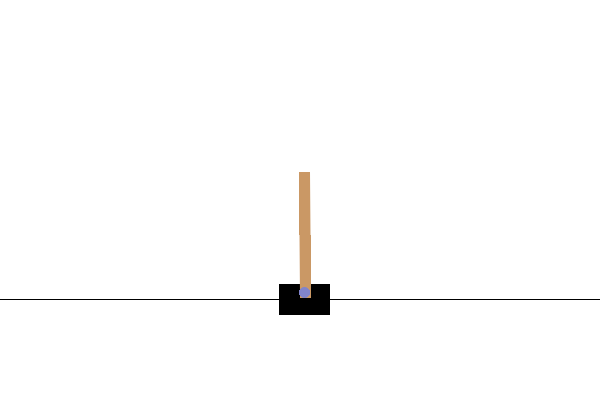

In [14]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## 次のステップ

このチュートリアルでは、TensorFlow を使って Actor-Critic 法を実装する方法を説明しました。

次のステップでは、Gym の別の環境でモデルをトレーニングしてみるとよいでしょう。

Actor-Critic 法と Cartpole-v0 問題に関するその他の詳細については、以下のリソースをご覧ください。

- [Actor-Critic 法](https://hal.inria.fr/hal-00840470/document)
- [Actor-Critic に関する講義（CAL）](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [Cart Pole learning control problem [Barto, et al. 1983]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)

TenSorFlow における強化学習のその他の例については、次のリソースをご覧ください。

- [強化学習のコードサンプル（keras.io）](https://keras.io/examples/rl/)
- [TF-Agents の強化学習用ライブラリ](https://www.tensorflow.org/agents)
